# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
### Why We're Here 

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

The required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# imports
import os
import numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from PIL import ImageFile

import cv2          
import matplotlib.pyplot as plt                       
%matplotlib inline

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


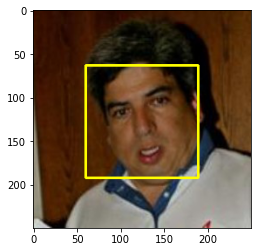

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[7])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Test the performance of the face_detector algorithm 
# on the images in human_files_short and dog_files_short.
f1 = 0
f2 = 0
for path in human_files_short:
    f1 += face_detector(path)

for path in dog_files_short:    
    f2 += face_detector(path)
    
print('Percentage of human faces detected in human_files_short: {}%'.format(f1))
print('Percentage of human faces detected in dog_files_short: {}%'.format(f2))

Percentage of human faces detected in human_files_short: 96%
Percentage of human faces detected in dog_files_short: 18%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](https://pytorch.org/docs/stable/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

Write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [7]:
# required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([transforms.Resize(size=(244, 244)),
                                    transforms.ToTensor()])
    img = transform(img)[:3,:,:].unsqueeze(0)
    return img

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Load and pre-process an image from the given img_path
    # Return the index of the predicted class for that image
    img = load_image(img_path)
    if use_cuda:
        img = img.cuda()
    pred = VGG16(img)
    return torch.max(pred, 1)[1].item()


In [8]:
VGG16_predict(dog_files_short[99])

273

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [9]:
# returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    idx = VGG16_predict(img_path)
    return idx >= 151 and idx <= 268

In [10]:
print(dog_detector(dog_files_short[1]))
print(dog_detector(human_files_short[1]))

True
False


### Assess the Dog Detector 
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [11]:
# Test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short.

s1 = 0
s2 = 0

for path in human_files_short:
    s1 += dog_detector(path)
for path in dog_files_short:
    s2 += dog_detector(path)

print('Percentage of images detected as dog in human_files_short: {}%'.format(s1))
print('Percentage of images detected as dog in dog_files_short: {}%'.format(s2))

Percentage of images detected as dog in human_files_short: 0%
Percentage of images detected as dog in dog_files_short: 93%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- |
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).

In [12]:
# write data loaders for training, validation, and test sets
# specify transforms, and batch_size
num_workers = 0
batch_size = 20

# from the pytorch torchvision models documentation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(256),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor(),
                                      normalize])
test_transform = transforms.Compose([transforms.Resize(size=(256, 256)),
                                     transforms.ToTensor(),
                                     normalize])
valid_transform = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      normalize])

dog_train_data = datasets.ImageFolder('dogImages/train', transform=train_transform)
dog_test_data = datasets.ImageFolder('dogImages/test', transform=test_transform)
dog_valid_data = datasets.ImageFolder('dogImages/valid', transform=valid_transform)

train_loader = torch.utils.data.DataLoader(dog_train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dog_test_data,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dog_valid_data,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=num_workers)

For the train and valid transformations, we used a Resize transform with a size value equal to 320. Then, we used a CenterCrop transform in order to return a cropped square image of size (256, 256). This is slightly smaller than most of the dog images, but big enough that it should still contain the most important features. In order to augment the training dataset, we added a RandomHorizontalFlip and RandomRotation transform. We did this to add some variability to the data as well as lower the chances of overfitting.

### Model Architecture

Create a CNN to classify dog breed.

In [13]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(8*8*128, 500)
        self.fc2 = nn.Linear(500, 133)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Define forward behavior
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 8*8*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return x

my_model = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    my_model.cuda()

We decided to have 3 convolutional layers with a pooling layer in between each, and two fully connected linear layers at the end. This simple network is a good starting point, but nothing in comparison to a pretrained transfer model.

### Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [14]:
# select loss function
criterion_scratch = nn.CrossEntropyLoss()

# select optimizer
optimizer_scratch = optim.SGD(my_model.parameters(), lr=0.02)

### Train and Validate the Model

Train and validate the model in the cells below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'my_model.pt'`.

In [15]:
loaders = {
    'train': train_loader,
    'test': test_loader,
    'valid': valid_loader
}

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for min validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find the loss and update model parameters

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                
        # validate the model #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save model if validation loss decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'my_model.pt')
            valid_loss_min = valid_loss    
    # return trained model
    return model

In [17]:
# train the model
my_model = train(20, loaders, my_model, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'my_model.pt')

# load the model that got the best validation accuracy
my_model.load_state_dict(torch.load('my_model.pt'))

Epoch: 1 	Training Loss: 4.885278 	Validation Loss: 4.873323
Validation loss decreased (inf --> 4.873323).  Saving model ...
Epoch: 2 	Training Loss: 4.843220 	Validation Loss: 4.801913
Validation loss decreased (4.873323 --> 4.801913).  Saving model ...
Epoch: 3 	Training Loss: 4.765545 	Validation Loss: 4.732990
Validation loss decreased (4.801913 --> 4.732990).  Saving model ...
Epoch: 4 	Training Loss: 4.657135 	Validation Loss: 4.620895
Validation loss decreased (4.732990 --> 4.620895).  Saving model ...
Epoch: 5 	Training Loss: 4.561657 	Validation Loss: 4.546868
Validation loss decreased (4.620895 --> 4.546868).  Saving model ...
Epoch: 6 	Training Loss: 4.477238 	Validation Loss: 4.466251
Validation loss decreased (4.546868 --> 4.466251).  Saving model ...
Epoch: 7 	Training Loss: 4.397966 	Validation Loss: 4.396761
Validation loss decreased (4.466251 --> 4.396761).  Saving model ...
Epoch: 8 	Training Loss: 4.322166 	Validation Loss: 4.448086
Epoch: 9 	Training Loss: 4.255881 

<All keys matched successfully>

### Test the Model

Try out my_model on the test dataset of dog images.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, my_model, criterion_scratch, use_cuda)

Test Loss: 4.047106


Test Accuracy: 10% (91/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Now use transfer learning to create a CNN that can identify dog breed from images.

In [19]:
# same loaders as before
loaders_transfer = loaders.copy()

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.

In [20]:
# Specify model architecture 
model_transfer = models.resnext50_32x4d(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048, 1024)
model_transfer.fc1 = nn.Linear(1024, 133)

# fc_parameters = model_transfer.fc1.parameters(), model_transfer.fc2.parameters()

for param in model_transfer.fc.parameters():
    param.requires_grad = True

for param in model_transfer.fc1.parameters():
    param.requires_grad = True
    
model_transfer

if use_cuda:
    model_transfer = model_transfer.cuda()

In [21]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

ResNext was the transfer model of choice because the publication results were appealing. We liked the adoption of repeating layers from the VGG/ResNets' strategy, as well as the split-transform-merge strategy. We exchanged the final fully connected layer for one that outputs 133 features, in accordance with the number of dog breeds.

### Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [22]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate the model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [23]:
# train the model

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #
        model_transfer.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find the loss and update the model parameters accordingly
            # record the average training loss, using something like
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
               
        # validate the model #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save model if validation loss decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss    
    # return trained model
    return model

In [24]:
# train the model
train(30, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.357076 	Validation Loss: 0.823375
Validation loss decreased (inf --> 0.823375).  Saving model ...
Epoch: 2 	Training Loss: 0.853312 	Validation Loss: 0.668938
Validation loss decreased (0.823375 --> 0.668938).  Saving model ...
Epoch: 3 	Training Loss: 0.664709 	Validation Loss: 0.559487
Validation loss decreased (0.668938 --> 0.559487).  Saving model ...
Epoch: 4 	Training Loss: 0.562458 	Validation Loss: 0.587942
Epoch: 5 	Training Loss: 0.516379 	Validation Loss: 0.496233
Validation loss decreased (0.559487 --> 0.496233).  Saving model ...
Epoch: 6 	Training Loss: 0.457423 	Validation Loss: 0.556920
Epoch: 7 	Training Loss: 0.437860 	Validation Loss: 0.636954
Epoch: 8 	Training Loss: 0.383064 	Validation Loss: 0.555833
Epoch: 9 	Training Loss: 0.399418 	Validation Loss: 0.540062
Epoch: 10 	Training Loss: 0.380773 	Validation Loss: 0.579565
Epoch: 11 	Training Loss: 0.346169 	Validation Loss: 0.547355
Epoch: 12 	Training Loss: 0.337224 	Validation Loss: 0.4

<All keys matched successfully>

### Test the Model

Try out the model on the test dataset of dog images.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.604078


Test Accuracy: 84% (703/836)


### Predict Dog Breed with the Model

Function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [26]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

In [27]:
class_names[:5]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute']

In [28]:
# same function as load_image with normalize transform

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     normalize])
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [29]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [30]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t prediction: {1}".format(img_path, prediction))

image_file_name: ./images\American_water_spaniel_00648.jpg, 	 prediction: American water spaniel
image_file_name: ./images\Brittany_02625.jpg, 	 prediction: Brittany
image_file_name: ./images\Curly-coated_retriever_03896.jpg, 	 prediction: Curly-coated retriever
image_file_name: ./images\Labrador_retriever_06449.jpg, 	 prediction: Labrador retriever
image_file_name: ./images\Labrador_retriever_06455.jpg, 	 prediction: Chesapeake bay retriever
image_file_name: ./images\Labrador_retriever_06457.jpg, 	 prediction: Labrador retriever
image_file_name: ./images\sample_cnn.png, 	 prediction: Dachshund
image_file_name: ./images\sample_dog_output.png, 	 prediction: Great dane
image_file_name: ./images\sample_human_output.png, 	 prediction: Cavalier king charles spaniel
image_file_name: ./images\Welsh_springer_spaniel_08203.jpg, 	 prediction: Irish red and white setter


---
<a id='step5'></a>
## Step 5: Write an Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

### Write the Algorithm

In [31]:
def run_app(img_path):
    # handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        predict = predict_breed_transfer(model_transfer, class_names, img_path)
        print('Dog detected...\nI\'d classify it as a(n) {}'.format(predict))  
    elif face_detector(img_path) > 0:
        predict = predict_breed_transfer(model_transfer, class_names, img_path)
        print('Human detected...\nI\'d say you look like a(n) {0}'.format(predict))
    else:
        print('Error: doesn\'t look like a dog or a human')

In [32]:
image_files = np.array(glob("images/*"))
print(image_files)

['images\\American_water_spaniel_00648.jpg' 'images\\Brittany_02625.jpg'
 'images\\Curly-coated_retriever_03896.jpg'
 'images\\Labrador_retriever_06449.jpg'
 'images\\Labrador_retriever_06455.jpg'
 'images\\Labrador_retriever_06457.jpg' 'images\\sample_cnn.png'
 'images\\sample_dog_output.png' 'images\\sample_human_output.png'
 'images\\Welsh_springer_spaniel_08203.jpg']


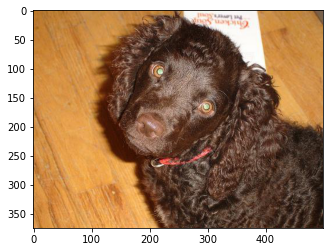

Dog detected...
I'd classify it as a(n) American water spaniel


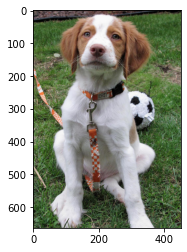

Dog detected...
I'd classify it as a(n) Brittany


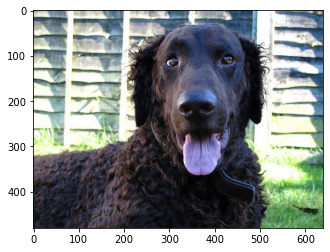

Dog detected...
I'd classify it as a(n) Curly-coated retriever


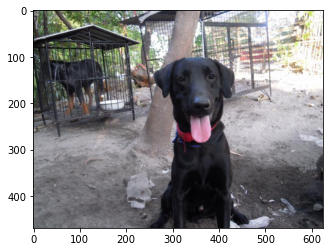

Dog detected...
I'd classify it as a(n) Labrador retriever


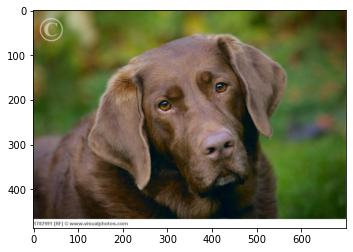

Dog detected...
I'd classify it as a(n) Chesapeake bay retriever


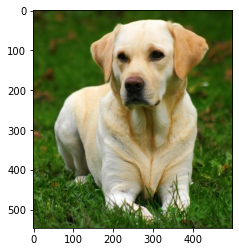

Dog detected...
I'd classify it as a(n) Labrador retriever


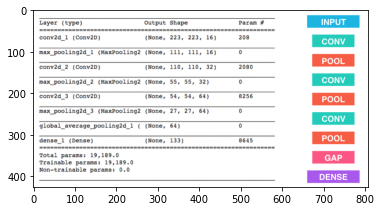

Error: doesn't look like a dog or a human


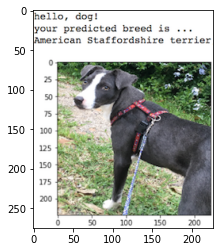

Dog detected...
I'd classify it as a(n) Great dane


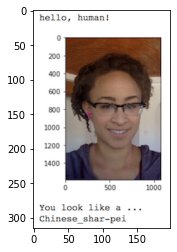

Human detected...
I'd say you look like a(n) Cavalier king charles spaniel


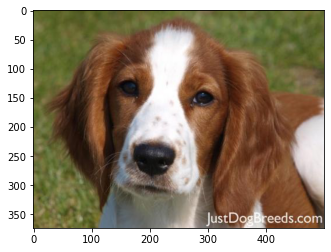

Dog detected...
I'd classify it as a(n) Irish red and white setter


In [33]:
for path in image_files:
    run_app(path)

---
<a id='step6'></a>
## Step 6: Test the Algorithm

Three possible points of improvement for the algorithm:
1. Specifying better parameters that lead to a lower validation loss during testing
2. Having a wider array of test images, so that the model may classify more accurately
3. Doing something different with the final fully connected layer that leads to a better classification model

In [34]:
my_files = np.array(glob("my_images/*"))
print(my_files)

['my_images\\cat_1.jpg' 'my_images\\dinosaur_1.jpg' 'my_images\\dog_1.JPG'
 'my_images\\dog_2.jpg' 'my_images\\human_1.png' 'my_images\\human_2.jpg']


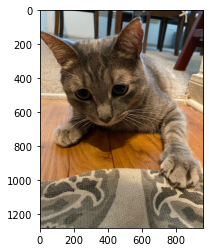

Error: doesn't look like a dog or a human


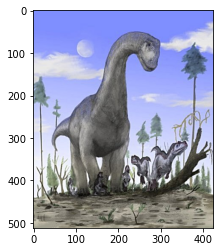

Error: doesn't look like a dog or a human


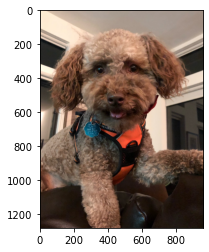

Dog detected...
I'd classify it as a(n) Poodle


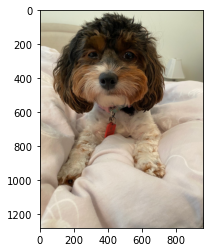

Dog detected...
I'd classify it as a(n) Havanese


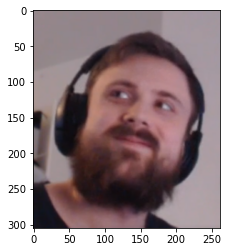

Human detected...
I'd say you look like a(n) Bichon frise


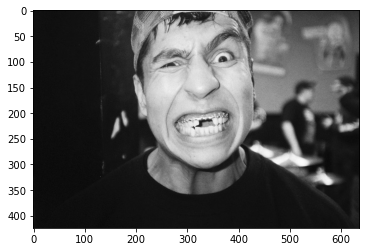

Human detected...
I'd say you look like a(n) Nova scotia duck tolling retriever


In [35]:
for path in my_files:
    run_app(path)

### STILL TODO:

Use Flask to produce an application that allows any user to input their own images. The model can then make predictions using these images.